# Joblib parallel backend context manager - Local Mode

In this notebook we demo how to use a context manager to change
the default backend used by the joblib implementation inside any
scikit-learn object that has a parameter `n_jobs`.

To run this notebook locally, you may need to install dask, either with

`conda install -c conda-forge dask-ml`

or

`pip install dask-ml`

Additionally, you may need to install Ray via

`pip install -U "ray[default]"`.

For more information see the [user guide](https://scikit-learn.org/stable/computing/parallelism.html).

In [1]:
import joblib
import dask
import ray

print(joblib.__version__)
print(dask.__version__)
print(ray.__version__)

1.2.0
2023.2.0
2.2.0


We build a classification task using :class:`~sklearn.datasets.make_classification` and cross-validate an :class:`~sklearn.ensemble.HistGradientBoostingClassifier` on top of it.

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1_000, random_state=0)

In [3]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gbdt = HistGradientBoostingClassifier(random_state=0)

In [4]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=100, random_state=0)

It is sometimes interesting to set a high number of splits `n_splits` to
to improve a model's analysis. As a consequence, the computional time
increases. We can reduce it by taking advantage of the parallelisation over
the parameter combinations evaluation by increasing the number of CPUs used
via the parameter `n_jobs`.

In [5]:
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from time import time
from joblib import parallel_backend
from sklearn.utils import parallel_backend as parallel_backend_sklearn

sns.set_style("darkgrid")


def bench(jobs, backend):
    durations = []
    for n_jobs in jobs:
        with parallel_backend(backend, n_jobs=n_jobs):
            tic = time()
            cross_validate(hist_gbdt, X, y, cv=cv)
            toc = time()
        durations.append(toc - tic)
    return durations


def bench_sklearn(jobs, backend):
    durations = []
    for n_jobs in jobs:
        with parallel_backend_sklearn(backend, n_jobs=n_jobs):
            tic = time()
            cross_validate(hist_gbdt, X, y, cv=cv)
            toc = time()
        durations.append(toc - tic)
    return durations


def plot_speedup_combined(jobs, results):
    
    fig = plt.figure(dpi=90)
    ax = sns.lineplot(x=jobs, y=jobs, color="black", label="linear growth")
    
    for result in results:
        backend, durations = list(result.values())
        speedup = durations[0] / durations
        label = f"{backend}"
        sns.lineplot(x=jobs, y=speedup, marker="o", ax=ax, label=label)
    
    ax.set(xscale="log", yscale="log");    
    ax.set_xticks(jobs);
    ax.set_xticklabels(jobs);
    ax.set_xlabel("number of jobs")
    ax.set_ylabel("speedup")
    ax.set_title("Speedup by backend and task type")
    plt.legend();

In [6]:
from ray.util.joblib import register_ray
from dask.distributed import Client

client = Client(processes=False) # init local dask client
ray.shutdown() # in case there is an open ray session
ray.init(num_cpus=32)
register_ray()

/home/arturoamor/miniforge3/envs/joblib-benchmark/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45909 instead
  warnings.warn(
2023-02-24 16:23:28,967	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 


In [7]:
jobs = [1, 2, 3, 4, 5, 8, 16, 32]
results = []

# for backend in ["loky", "threading", "ray", "dask"]:
for backend in ["loky"]:
    durations = bench(jobs, backend)
    title = f"{backend}"
    results.append(
        dict(
            backend=backend,
            durations=np.array(durations),
        )
    )

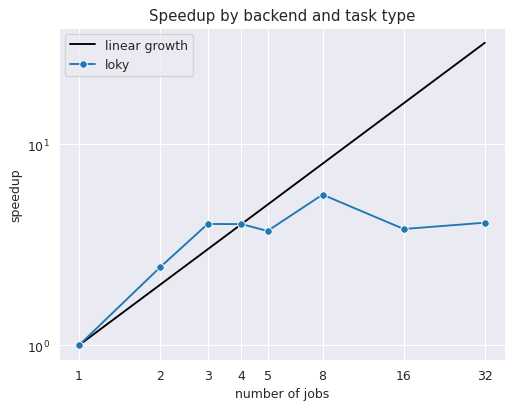

In [8]:
plot_speedup_combined(jobs, results)

In [9]:
# results = [] # un-comment to have independent plots

# for backend in ["loky", "threading", "ray", "dask"]:
for backend in ["loky"]:
    durations = bench_sklearn(jobs, backend)
    title = f"{backend} - sklearn"
    results.append(
        dict(
            backend=backend,
            durations=np.array(durations),
        )
    )

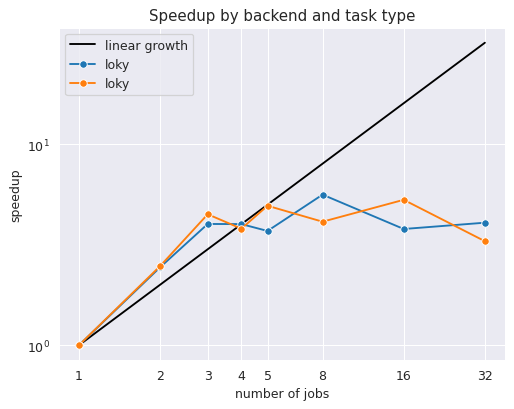

In [10]:
plot_speedup_combined(jobs, results)